# Student Performance Prediction Model

This notebook implements a predictive model for student academic performance using:
1. Linear regression for score prediction based on demographic and academic factors
2. Fuzzy logic system to model subjective factors like effort based on attendance and study time
3. Integration of both approaches for more nuanced predictions

The final model is saved as a pickle file that can be used by the Flask backend.

## Features used:
- gender
- race/ethnicity
- parental level of education
- lunch
- test preparation course
- Fuzzy inputs: attendance rate, study time, motivation level

## Outputs:
- Predicted math, reading, and writing scores
- Overall performance assessment
- Personalized recommendations

In [2]:
pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 639.7 kB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import skfuzzy as fuzz
from skfuzzy import control as ctrl

print("imported all")

imported all


In [4]:
# Load the dataset
# If using the Kaggle dataset:
df = pd.read_csv('../dataset/StudentsPerformance.csv')

# Initial exploration
print(f"Dataset shape: {df.shape}")
df.head()

# Check for missing values
df.isnull().sum()

# Get statistical summary
df.describe()

# Check data types
df.info()

Dataset shape: (1000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


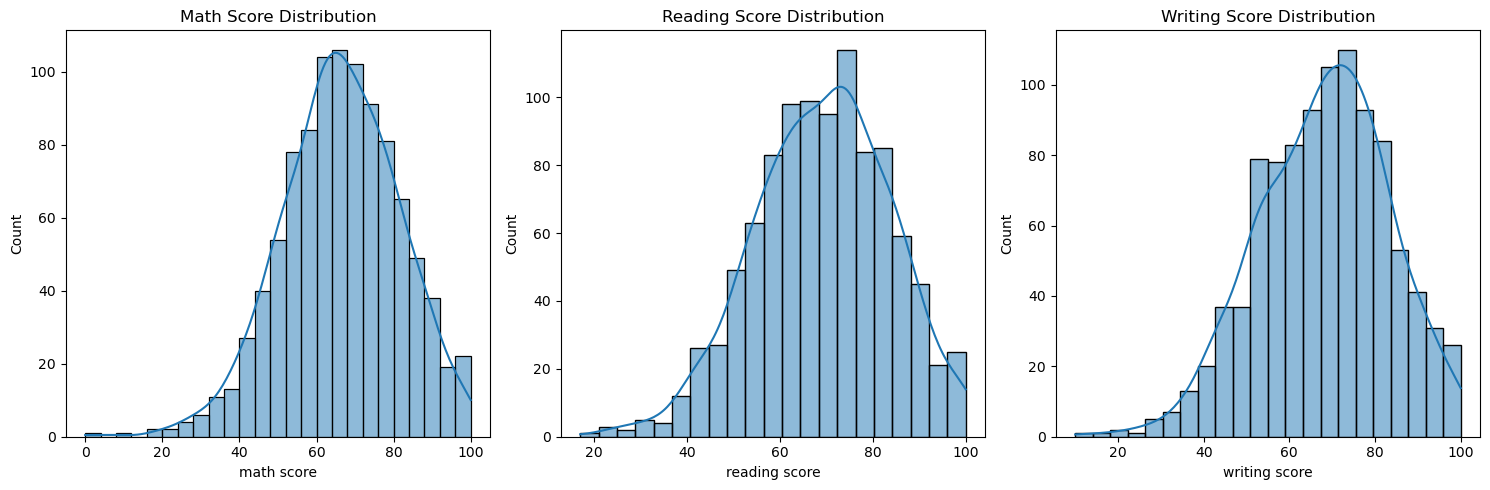

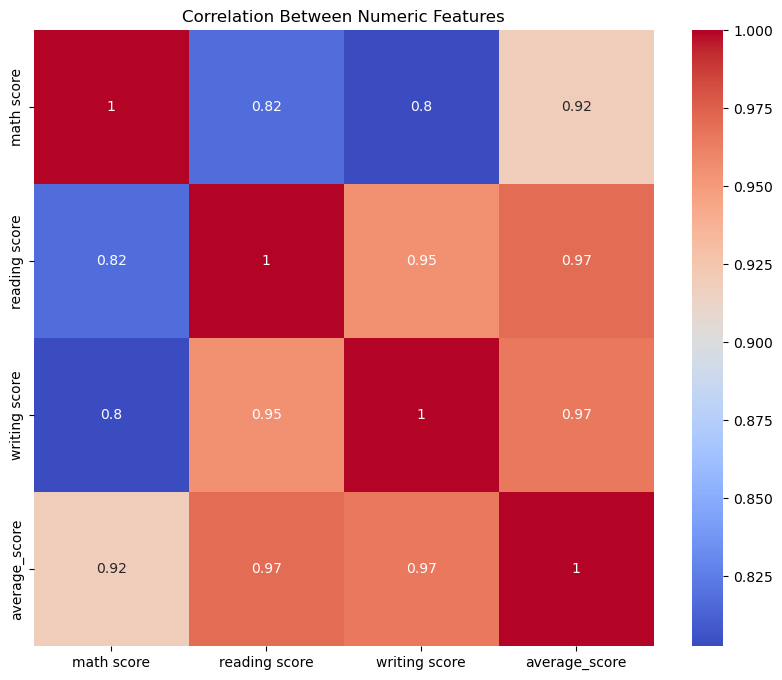

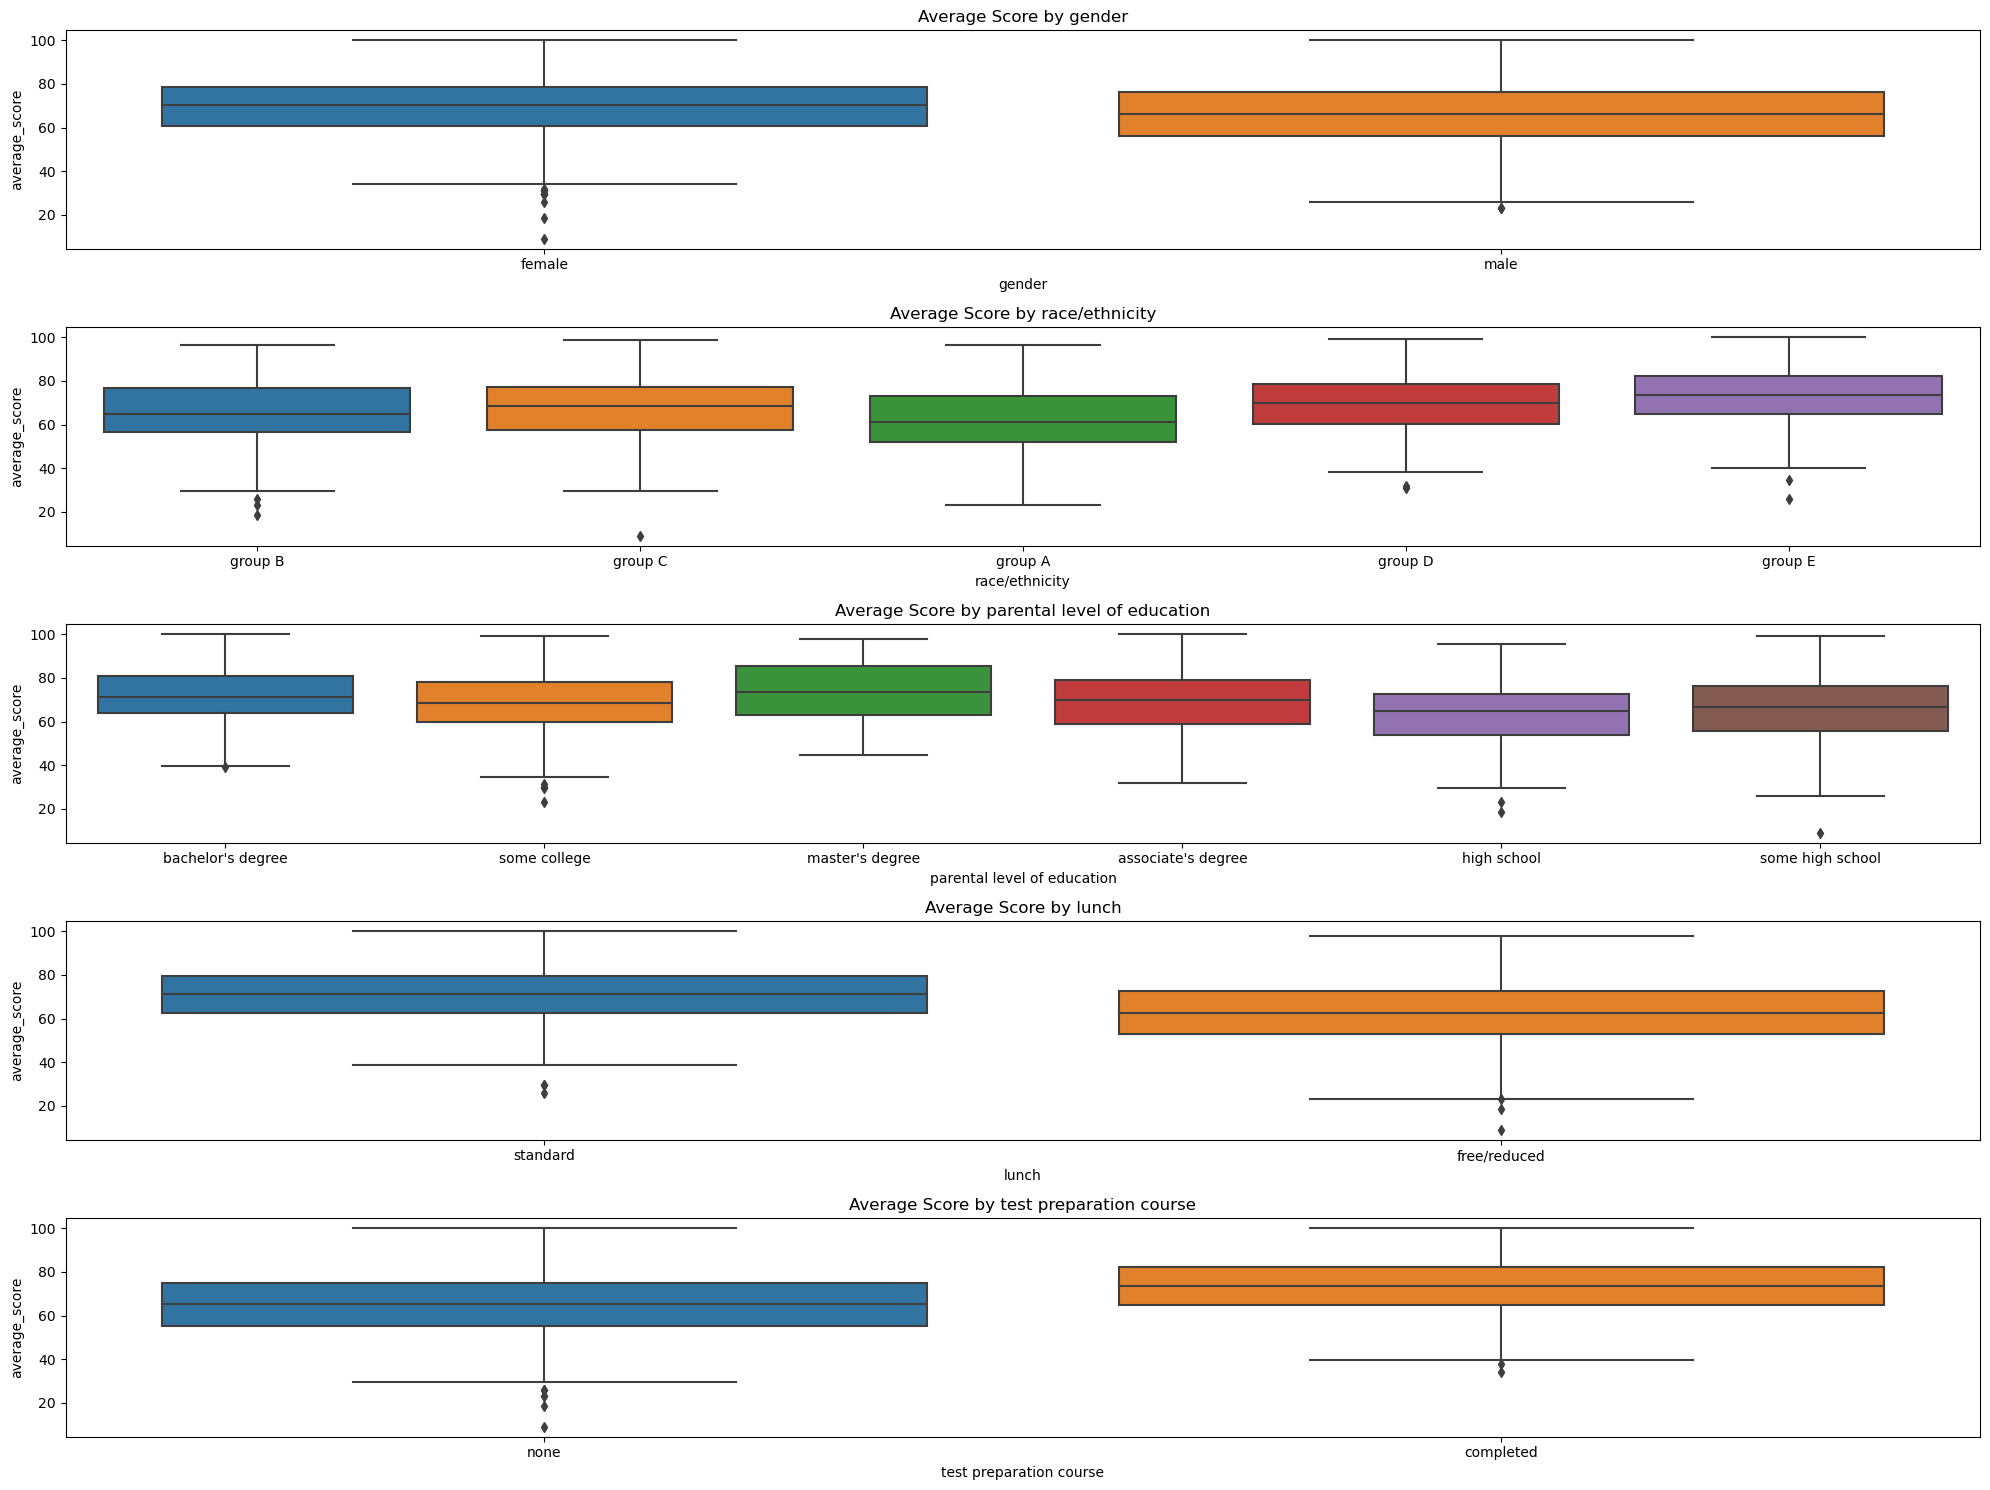

In [5]:
# Plot distribution of scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['math score'], kde=True)
plt.title('Math Score Distribution')

plt.subplot(1, 3, 2)
sns.histplot(df['reading score'], kde=True)
plt.title('Reading Score Distribution')

plt.subplot(1, 3, 3)
sns.histplot(df['writing score'], kde=True)
plt.title('Writing Score Distribution')

plt.tight_layout()
plt.show()

# Create average score column
df['average_score'] = (df['math score'] + df['reading score'] + df['writing score']) / 3

# Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Numeric Features')
plt.show()

# Categorical features analysis
plt.figure(figsize=(20, 15))
categorical_cols = df.select_dtypes(include=['object']).columns

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, i)
    sns.boxplot(x=col, y='average_score', data=df)
    plt.title(f'Average Score by {col}')
    plt.tight_layout()

plt.show()

Attendance: 30%, Study time: 5h/week, Effort level: 15.56/100
Attendance: 50%, Study time: 15h/week, Effort level: 50.00/100
Attendance: 90%, Study time: 30h/week, Effort level: 84.44/100


/opt/anaconda3/lib/python3.9/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


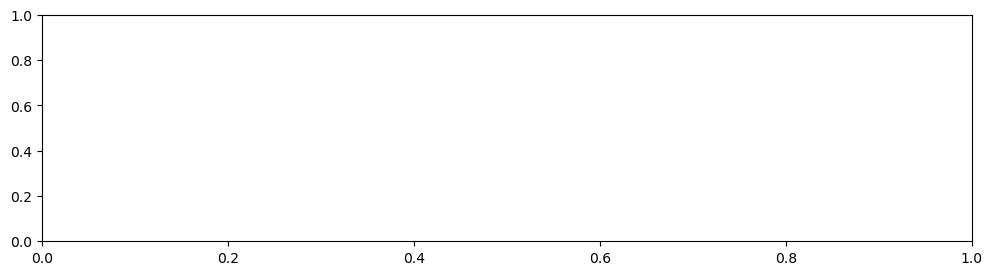

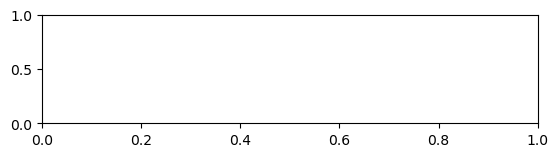

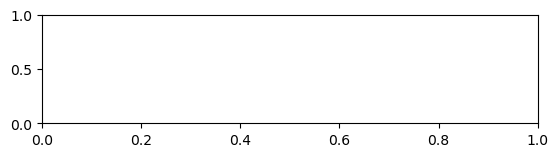

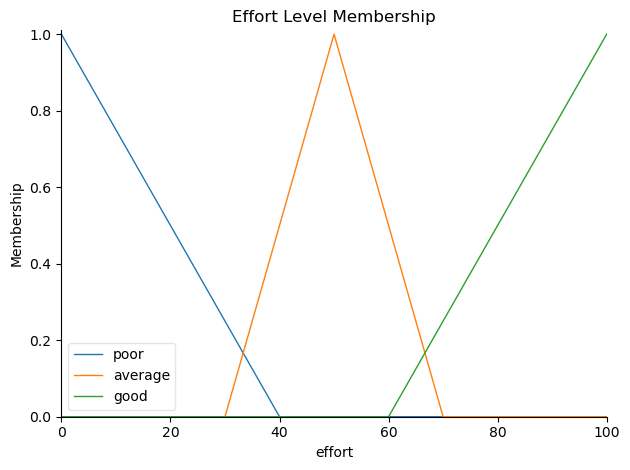

In [6]:
# Create fuzzy logic system for effort level based on attendance and study time
# Note: In the actual implementation, these would be inputs from the user

# New universe variables for inputs and output
attendance = ctrl.Antecedent(np.arange(0, 101, 1), 'attendance')
study_time = ctrl.Antecedent(np.arange(0, 41, 1), 'study_time')
effort = ctrl.Consequent(np.arange(0, 101, 1), 'effort')

# Auto-membership function population
attendance['low'] = fuzz.trimf(attendance.universe, [0, 0, 60])
attendance['medium'] = fuzz.trimf(attendance.universe, [40, 70, 90])
attendance['high'] = fuzz.trimf(attendance.universe, [75, 100, 100])

study_time['minimal'] = fuzz.trimf(study_time.universe, [0, 0, 10])
study_time['moderate'] = fuzz.trimf(study_time.universe, [5, 15, 25])
study_time['extensive'] = fuzz.trimf(study_time.universe, [20, 40, 40])

effort['poor'] = fuzz.trimf(effort.universe, [0, 0, 40])
effort['average'] = fuzz.trimf(effort.universe, [30, 50, 70])
effort['good'] = fuzz.trimf(effort.universe, [60, 100, 100])

# Define fuzzy rules
rule1 = ctrl.Rule(attendance['low'] & study_time['minimal'], effort['poor'])
rule2 = ctrl.Rule(attendance['low'] & study_time['moderate'], effort['average'])
rule3 = ctrl.Rule(attendance['low'] & study_time['extensive'], effort['average'])
rule4 = ctrl.Rule(attendance['medium'] & study_time['minimal'], effort['average'])
rule5 = ctrl.Rule(attendance['medium'] & study_time['moderate'], effort['average'])
rule6 = ctrl.Rule(attendance['medium'] & study_time['extensive'], effort['good'])
rule7 = ctrl.Rule(attendance['high'] & study_time['minimal'], effort['average'])
rule8 = ctrl.Rule(attendance['high'] & study_time['moderate'], effort['good'])
rule9 = ctrl.Rule(attendance['high'] & study_time['extensive'], effort['good'])

# Create control system
effort_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])

# Create simulator
effort_simulator = ctrl.ControlSystemSimulation(effort_ctrl)

# Define a function to compute effort level
def compute_effort(attendance_val, study_time_val):
    effort_simulator.input['attendance'] = attendance_val
    effort_simulator.input['study_time'] = study_time_val
    effort_simulator.compute()
    return effort_simulator.output['effort']

# Test with a few values
test_cases = [
    (30, 5),  # Low attendance, minimal study
    (50, 15), # Medium attendance, moderate study
    (90, 30)  # High attendance, extensive study
]

for att, st in test_cases:
    effort_val = compute_effort(att, st)
    print(f"Attendance: {att}%, Study time: {st}h/week, Effort level: {effort_val:.2f}/100")

# Visualize the fuzzy membership functions
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
attendance.view()
plt.title('Attendance Membership')

plt.subplot(3, 1, 2)
study_time.view()
plt.title('Study Time Membership')

plt.subplot(3, 1, 3)
effort.view()
plt.title('Effort Level Membership')

plt.tight_layout()
plt.show()

In [7]:
# Prepare data for modeling
# Create feature engineering function
def preprocess_data(df):
    # Create copy to avoid modifying original
    data = df.copy()
    
    # Create average score if it doesn't exist
    if 'average_score' not in data.columns:
        data['average_score'] = (data['math score'] + data['reading score'] + data['writing score']) / 3
    
    # Define features and target
    X = data.drop(['math score', 'reading score', 'writing score', 'average_score'], axis=1)
    y_math = data['math score']
    y_reading = data['reading score']
    y_writing = data['writing score']
    
    return X, y_math, y_reading, y_writing

# Apply preprocessing
X, y_math, y_reading, y_writing = preprocess_data(df)

# Split data into train and test sets
X_train, X_test, y_math_train, y_math_test, y_reading_train, y_reading_test, y_writing_train, y_writing_test = train_test_split(
    X, y_math, y_reading, y_writing, test_size=0.2, random_state=42
)

# Define categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)

Math Score Model:
RMSE: 14.16
R²: 0.1760

Reading Score Model:
RMSE: 13.79
R²: 0.1594

Writing Score Model:
RMSE: 13.32
R²: 0.2637


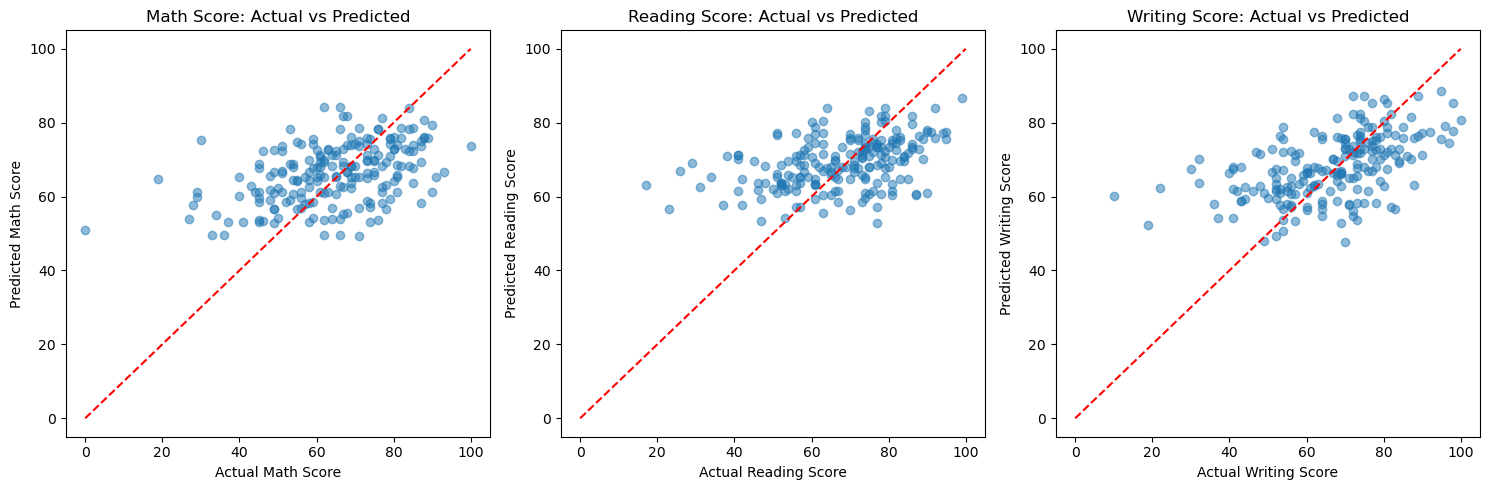

In [8]:
# Create pipeline for math score
math_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Create pipeline for reading score
reading_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Create pipeline for writing score
writing_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the models
math_pipeline.fit(X_train, y_math_train)
reading_pipeline.fit(X_train, y_reading_train)
writing_pipeline.fit(X_train, y_writing_train)

# Make predictions
y_math_pred = math_pipeline.predict(X_test)
y_reading_pred = reading_pipeline.predict(X_test)
y_writing_pred = writing_pipeline.predict(X_test)

# Evaluate model performance
math_rmse = np.sqrt(mean_squared_error(y_math_test, y_math_pred))
math_r2 = r2_score(y_math_test, y_math_pred)

reading_rmse = np.sqrt(mean_squared_error(y_reading_test, y_reading_pred))
reading_r2 = r2_score(y_reading_test, y_reading_pred)

writing_rmse = np.sqrt(mean_squared_error(y_writing_test, y_writing_pred))
writing_r2 = r2_score(y_writing_test, y_writing_pred)

# Print evaluation metrics
print("Math Score Model:")
print(f"RMSE: {math_rmse:.2f}")
print(f"R²: {math_r2:.4f}")

print("\nReading Score Model:")
print(f"RMSE: {reading_rmse:.2f}")
print(f"R²: {reading_r2:.4f}")

print("\nWriting Score Model:")
print(f"RMSE: {writing_rmse:.2f}")
print(f"R²: {writing_r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_math_test, y_math_pred, alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Math Score: Actual vs Predicted')

plt.subplot(1, 3, 2)
plt.scatter(y_reading_test, y_reading_pred, alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Actual Reading Score')
plt.ylabel('Predicted Reading Score')
plt.title('Reading Score: Actual vs Predicted')

plt.subplot(1, 3, 3)
plt.scatter(y_writing_test, y_writing_pred, alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('Actual Writing Score')
plt.ylabel('Predicted Writing Score')
plt.title('Writing Score: Actual vs Predicted')

plt.tight_layout()
plt.show()

In [9]:
# Create a function that combines fuzzy logic and regression models
def predict_performance(student_data, attendance_val, study_time_val, motivation_val=None):
    """
    Predict student performance using both regression models and fuzzy logic
    
    Parameters:
    - student_data: DataFrame with a single row containing student features
    - attendance_val: Attendance percentage (0-100)
    - study_time_val: Weekly study hours (0-40)
    - motivation_val: Optional motivation score (0-100)
    
    Returns:
    - Dictionary with predicted scores and recommendations
    """
    # Calculate effort using fuzzy logic
    effort_score = compute_effort(attendance_val, study_time_val)
    
    # Get base predictions from regression models
    math_pred = math_pipeline.predict(student_data)[0]
    reading_pred = reading_pipeline.predict(student_data)[0]
    writing_pred = writing_pipeline.predict(student_data)[0]
    
    # Adjust predictions based on effort
    # If effort is high, boost predictions, if low, reduce them
    effort_factor = (effort_score - 50) / 50  # -1 to 1 scale
    
    # Apply effort adjustment (max ±10 points)
    math_adjusted = math_pred + (effort_factor * 10)
    reading_adjusted = reading_pred + (effort_factor * 10)
    writing_adjusted = writing_pred + (effort_factor * 10)
    
    # Ensure scores stay within 0-100 range
    math_adjusted = max(0, min(100, math_adjusted))
    reading_adjusted = max(0, min(100, reading_adjusted))
    writing_adjusted = max(0, min(100, writing_adjusted))
    
    # Calculate average
    avg_adjusted = (math_adjusted + reading_adjusted + writing_adjusted) / 3
    
    # Generate recommendations based on scores and effort
    recommendations = []
    
    if effort_score < 40:
        recommendations.append("Consider increasing your attendance and study time to improve performance.")
    
    if math_adjusted < 60:
        recommendations.append("Your math performance needs improvement. Additional practice with problem-solving exercises is recommended.")
    
    if reading_adjusted < 60:
        recommendations.append("Focus on improving your reading skills through regular reading practice.")
    
    if writing_adjusted < 60:
        recommendations.append("Work on enhancing your writing skills through regular practice and feedback.")
    
    if avg_adjusted >= 80:
        recommendations.append("You're doing well overall! Keep up the good work.")
    
    # Compile results
    results = {
        'math_score': math_adjusted,
        'reading_score': reading_adjusted,
        'writing_score': writing_adjusted,
        'average_score': avg_adjusted,
        'effort_level': effort_score,
        'recommendations': recommendations
    }
    
    return results

# Test the combined model with a sample student
sample_student = X_test.iloc[[0]]  # Just using the first test row as an example
sample_result = predict_performance(sample_student, attendance_val=85, study_time_val=20)

print("Sample Prediction Results:")
for key, value in sample_result.items():
    if key != 'recommendations':
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}:")
        for rec in value:
            print(f"- {rec}")

Sample Prediction Results:
math_score: 69.38
reading_score: 77.39
writing_score: 76.91
average_score: 74.56
effort_level: 70.17
recommendations:


In [10]:
# Create a model package that includes all components
model_package = {
    'math_model': math_pipeline,
    'reading_model': reading_pipeline,
    'writing_model': writing_pipeline,
    'fuzzy_effort_simulator': effort_simulator,
    'predict_performance': predict_performance,
    'compute_effort': compute_effort,
    'feature_names': list(X.columns)
}

# Save the model package
with open('student_performance_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Model saved successfully as 'student_performance_model.pkl'")

# Test loading the model
with open('student_performance_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully. Available components:")
for key in loaded_model.keys():
    print(f"- {key}")

Model saved successfully as 'student_performance_model.pkl'
Model loaded successfully. Available components:
- math_model
- reading_model
- writing_model
- fuzzy_effort_simulator
- predict_performance
- compute_effort
- feature_names


In [11]:
# Function to be used by the Flask backend
def predict_from_form(form_data):
    """
    Function that the Flask backend can use to process form data and make predictions
    
    Parameters:
    - form_data: Dictionary containing form inputs
    
    Returns:
    - Dictionary with predictions and recommendations
    """
    # Extract data from form
    gender = form_data.get('gender')
    race_ethnicity = form_data.get('race_ethnicity')
    parental_education = form_data.get('parental_education')
    lunch = form_data.get('lunch')
    test_preparation = form_data.get('test_preparation')
    
    # Additional fuzzy inputs
    attendance = float(form_data.get('attendance', 0))
    study_time = float(form_data.get('study_time', 0))
    motivation = float(form_data.get('motivation', 50))
    
    # Current scores (if available)
    current_math = float(form_data.get('math_score', 0))
    current_reading = float(form_data.get('reading_score', 0))
    current_writing = float(form_data.get('writing_score', 0))
    
    # Create a dataframe with the student data
    student_data = pd.DataFrame({
        'gender': [gender],
        'race/ethnicity': [race_ethnicity],
        'parental level of education': [parental_education],
        'lunch': [lunch],
        'test preparation course': [test_preparation]
    })
    
    # Make prediction
    prediction = predict_performance(student_data, attendance, study_time, motivation)
    
    # Add improvement calculations if current scores are provided
    if current_math > 0 and current_reading > 0 and current_writing > 0:
        prediction['math_improvement'] = prediction['math_score'] - current_math
        prediction['reading_improvement'] = prediction['reading_score'] - current_reading
        prediction['writing_improvement'] = prediction['writing_score'] - current_writing
        prediction['average_improvement'] = (prediction['math_improvement'] + 
                                           prediction['reading_improvement'] + 
                                           prediction['writing_improvement']) / 3
    
    return prediction

# Save this function with the model
model_package['predict_from_form'] = predict_from_form

# Save the updated model package
with open('student_performance_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Updated model saved with Flask interface function")

Updated model saved with Flask interface function


# Testing Model

Loading model from: student_performance_model.pkl
No test data provided, loading original dataset...
Testing model on 200 samples

=== Regression Model Performance ===
Math Score - RMSE: 14.16, MAE: 11.27, R²: 0.1760
Reading Score - RMSE: 13.79, MAE: 10.83, R²: 0.1594
Writing Score - RMSE: 13.32, MAE: 10.19, R²: 0.2637


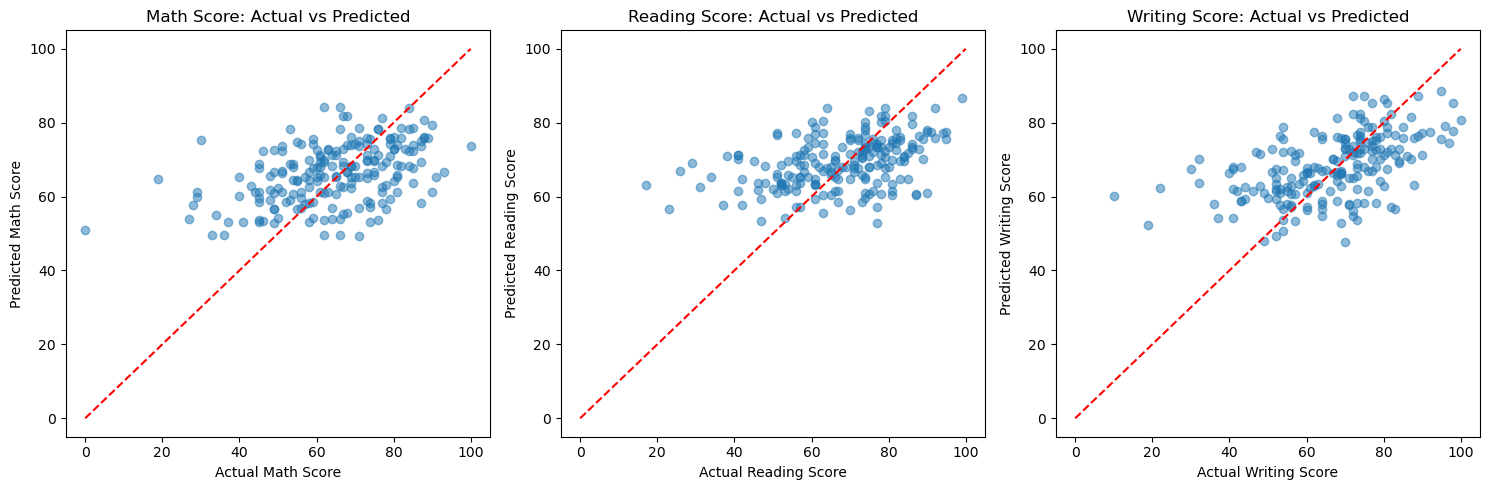


=== Fuzzy Logic Component Testing ===
Low attendance, minimal study: Attendance=20%, Study time=5h/week → Effort level=15.56/100
Medium attendance, low study: Attendance=50%, Study time=10h/week → Effort level=50.00/100
Medium attendance, medium study: Attendance=60%, Study time=20h/week → Effort level=50.00/100
High attendance, medium study: Attendance=85%, Study time=15h/week → Effort level=70.17/100
High attendance, high study: Attendance=95%, Study time=30h/week → Effort level=84.44/100

=== Combined Model Testing ===

Test Case 1:
Student 0 with attendance=30%, study_time=5h/week
Calculated effort level: 15.56/100

Actual vs Predicted Scores:
Math: 91.0 vs 58.5
Reading: 86.0 vs 66.5
Writing: 84.0 vs 66.0
Average: 87.0 vs 63.6

Recommendations:
- Consider increasing your attendance and study time to improve performance.
- Your math performance needs improvement. Additional practice with problem-solving exercises is recommended.

Test Case 2:
Student 0 with attendance=60%, study_ti

In [14]:
def test_student_performance_model(model_path, test_data=None, test_size=0.2, random_state=42):
    """
    Test the Student Performance Prediction model with various inputs and evaluate its performance.
    
    Parameters:
    -----------
    model_path : str
        Path to the pickled model file
    test_data : DataFrame, optional
        Test dataset to use. If None, will use a portion of the original dataset
    test_size : float, optional
        Portion of data to use for testing if test_data is None
    random_state : int, optional
        Random seed for reproducibility
        
    Returns:
    --------
    dict
        Dictionary containing test results and metrics
    """
    import pickle
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    
    # Load the model
    print("Loading model from:", model_path)
    with open(model_path, 'rb') as f:
        model_package = pickle.load(f)
    
    # Extract model components
    math_model = model_package['math_model']
    reading_model = model_package['reading_model']
    writing_model = model_package['writing_model']
    compute_effort = model_package['compute_effort']
    predict_performance = model_package['predict_performance']
    
    # If no test data provided, load original dataset and create a test set
    if test_data is None:
        print("No test data provided, loading original dataset...")
        # Update this path to your dataset location
        df = pd.read_csv('../dataset/StudentsPerformance.csv')
        
        # Prepare features and targets
        X = df.drop(['math score', 'reading score', 'writing score'], axis=1)
        y_math = df['math score']
        y_reading = df['reading score']
        y_writing = df['writing score']
        
        # Split data
        from sklearn.model_selection import train_test_split
        _, X_test, _, y_math_test, _, y_reading_test, _, y_writing_test = train_test_split(
            X, y_math, y_reading, y_writing, test_size=test_size, random_state=random_state
        )
        
        test_data = X_test.copy()
        test_data['math score'] = y_math_test.values
        test_data['reading score'] = y_reading_test.values
        test_data['writing score'] = y_writing_test.values
    
    print(f"Testing model on {len(test_data)} samples")
    
    # Test regression models
    X_test = test_data.drop(['math score', 'reading score', 'writing score'], axis=1, errors='ignore')
    
    if 'math score' in test_data.columns:
        y_math_test = test_data['math score']
        y_reading_test = test_data['reading score']
        y_writing_test = test_data['writing score']
        
        # Make predictions
        y_math_pred = math_model.predict(X_test)
        y_reading_pred = reading_model.predict(X_test)
        y_writing_pred = writing_model.predict(X_test)
        
        # Calculate metrics
        results = {
            'math_rmse': np.sqrt(mean_squared_error(y_math_test, y_math_pred)),
            'math_mae': mean_absolute_error(y_math_test, y_math_pred),
            'math_r2': r2_score(y_math_test, y_math_pred),
            
            'reading_rmse': np.sqrt(mean_squared_error(y_reading_test, y_reading_pred)),
            'reading_mae': mean_absolute_error(y_reading_test, y_reading_pred),
            'reading_r2': r2_score(y_reading_test, y_reading_pred),
            
            'writing_rmse': np.sqrt(mean_squared_error(y_writing_test, y_writing_pred)),
            'writing_mae': mean_absolute_error(y_writing_test, y_writing_pred),
            'writing_r2': r2_score(y_writing_test, y_writing_pred),
        }
        
        # Print metrics
        print("\n=== Regression Model Performance ===")
        print(f"Math Score - RMSE: {results['math_rmse']:.2f}, MAE: {results['math_mae']:.2f}, R²: {results['math_r2']:.4f}")
        print(f"Reading Score - RMSE: {results['reading_rmse']:.2f}, MAE: {results['reading_mae']:.2f}, R²: {results['reading_r2']:.4f}")
        print(f"Writing Score - RMSE: {results['writing_rmse']:.2f}, MAE: {results['writing_mae']:.2f}, R²: {results['writing_r2']:.4f}")
        
        # Visualize predictions vs actual
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.scatter(y_math_test, y_math_pred, alpha=0.5)
        plt.plot([0, 100], [0, 100], 'r--')
        plt.xlabel('Actual Math Score')
        plt.ylabel('Predicted Math Score')
        plt.title('Math Score: Actual vs Predicted')
        
        plt.subplot(1, 3, 2)
        plt.scatter(y_reading_test, y_reading_pred, alpha=0.5)
        plt.plot([0, 100], [0, 100], 'r--')
        plt.xlabel('Actual Reading Score')
        plt.ylabel('Predicted Reading Score')
        plt.title('Reading Score: Actual vs Predicted')
        
        plt.subplot(1, 3, 3)
        plt.scatter(y_writing_test, y_writing_pred, alpha=0.5)
        plt.plot([0, 100], [0, 100], 'r--')
        plt.xlabel('Actual Writing Score')
        plt.ylabel('Predicted Writing Score')
        plt.title('Writing Score: Actual vs Predicted')
        
        plt.tight_layout()
        plt.show()
    
    # Test fuzzy logic component
    print("\n=== Fuzzy Logic Component Testing ===")
    test_attendance_study_pairs = [
        (20, 5, "Low attendance, minimal study"),
        (50, 10, "Medium attendance, low study"),
        (60, 20, "Medium attendance, medium study"),
        (85, 15, "High attendance, medium study"),
        (95, 30, "High attendance, high study")
    ]
    
    for att, study, desc in test_attendance_study_pairs:
        effort = compute_effort(att, study)
        print(f"{desc}: Attendance={att}%, Study time={study}h/week → Effort level={effort:.2f}/100")
    
    # Test combined model with sample cases
    print("\n=== Combined Model Testing ===")
    # Use a few samples from the test data with different fuzzy inputs
    if len(X_test) >= 5:
        sample_indices = [0, min(len(X_test)-1, 10), min(len(X_test)-1, 20)]
    else:
        sample_indices = range(len(X_test))
    
    attendance_study_pairs = [
        (30, 5),  # Low attendance, low study
        (60, 15), # Medium attendance, medium study
        (90, 30)  # High attendance, high study
    ]
    
    combined_results = []
    
    for idx in sample_indices:
        student = X_test.iloc[[idx]]
        
        for att, study in attendance_study_pairs:
            prediction = predict_performance(student, att, study)
            
            result = {
                'student_idx': idx,
                'attendance': att,
                'study_time': study,
                'effort_level': prediction['effort_level'],
                'predicted_math': prediction['math_score'],
                'predicted_reading': prediction['reading_score'],
                'predicted_writing': prediction['writing_score'],
                'predicted_avg': prediction['average_score'],
                'recommendations': prediction['recommendations']
            }
            
            # Add actual scores if available
            if 'math score' in test_data.columns:
                result['actual_math'] = test_data.iloc[idx]['math score']
                result['actual_reading'] = test_data.iloc[idx]['reading score']
                result['actual_writing'] = test_data.iloc[idx]['writing score']
                result['actual_avg'] = (result['actual_math'] + result['actual_reading'] + result['actual_writing']) / 3
            
            combined_results.append(result)
    
    # Print combined results
    for i, result in enumerate(combined_results):
        print(f"\nTest Case {i+1}:")
        print(f"Student {result['student_idx']} with attendance={result['attendance']}%, study_time={result['study_time']}h/week")
        print(f"Calculated effort level: {result['effort_level']:.2f}/100")
        
        if 'actual_math' in result:
            print("\nActual vs Predicted Scores:")
            print(f"Math: {result['actual_math']:.1f} vs {result['predicted_math']:.1f}")
            print(f"Reading: {result['actual_reading']:.1f} vs {result['predicted_reading']:.1f}")
            print(f"Writing: {result['actual_writing']:.1f} vs {result['predicted_writing']:.1f}")
            print(f"Average: {result['actual_avg']:.1f} vs {result['predicted_avg']:.1f}")
        else:
            print("\nPredicted Scores:")
            print(f"Math: {result['predicted_math']:.1f}")
            print(f"Reading: {result['predicted_reading']:.1f}")
            print(f"Writing: {result['predicted_writing']:.1f}")
            print(f"Average: {result['predicted_avg']:.1f}")
        
        print("\nRecommendations:")
        for rec in result['recommendations']:
            print(f"- {rec}")
    
    # Test predict_from_form function if available
    if 'predict_from_form' in model_package:
        print("\n=== Testing predict_from_form function ===")
        predict_from_form = model_package['predict_from_form']
        
        # Create a sample form data dictionary
        sample_form = {
            'gender': 'female',
            'race_ethnicity': 'group C',
            'parental_education': 'bachelor\'s degree',
            'lunch': 'standard',
            'test_preparation': 'completed',
            'attendance': 75,
            'study_time': 20,
            'motivation': 80,
            'math_score': 70,
            'reading_score': 75,
            'writing_score': 80
        }
        
        form_prediction = predict_from_form(sample_form)
        
        print("Form Data Input:")
        for key, value in sample_form.items():
            print(f"- {key}: {value}")
        
        print("\nPrediction Results:")
        for key, value in form_prediction.items():
            if key != 'recommendations':
                if isinstance(value, (int, float)):
                    print(f"- {key}: {value:.2f}")
                else:
                    print(f"- {key}: {value}")
            else:
                print(f"- {key}:")
                for rec in value:
                    print(f"  * {rec}")
    
    return {
        'regression_metrics': results if 'math score' in test_data.columns else None,
        'fuzzy_logic_tests': test_attendance_study_pairs,
        'combined_results': combined_results,
        'model_structure': list(model_package.keys())
    }

# Example usage:
test_results = test_student_performance_model('student_performance_model.pkl')